In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import seaborn as sns

In [2]:
fare_revenue_data = pd.read_csv('cleaned_fare_revenue_data.csv')
federal_funding_data = pd.read_excel('cleaned_federal_funding.xlsx')

In [3]:
# road transportation modes
road_transport_modes = ['MB', 'CB', 'DR', 'VP', 'RB', 'PB']

# Filtering dataset
fare_revenue_road = fare_revenue_data[fare_revenue_data['mode'].isin(road_transport_modes)]
federal_funding_road = federal_funding_data[federal_funding_data['Mode'].isin(road_transport_modes)]

# Merge datasets using the common key ('ntd_id' / 'NTD ID')
merged_data = pd.merge(
    fare_revenue_road,
    federal_funding_road,
    left_on='ntd_id',
    right_on='NTD ID',
    suffixes=('_fare', '_funding')
)

merged_data.head()


,ntd_id,agency_name,reporting_module,mode,expense_type,passenger_paid_fares,organization_paid_fares,total_fares,UACE Code,UZA Name,...,Non-Fixed Guideway Passenger Miles,Non-Fixed Guideway Operating Expenses,Directional Route Miles,Fixed Guideway Vehicle Revenue Miles,Fixed Guideway Passenger Miles,Fixed Guideway Operating Expenses,SGR FG Directional Route Miles,SGR FG Vehicle Revenue Miles,SGR HIB Directional Route Miles,SGR HIB Vehicle Revenue Miles
0,1,King County Department of Metro Transit,Urban,CB,Funds Earned During Period,1927211,3289701.0,5216912.0,80389,"Seattle--Tacoma, WA",...,5546871,54748982,0.0,0,0,0,0.0,0,0.0,0
1,1,King County Department of Metro Transit,Urban,CB,Funds Earned During Period,1927211,3289701.0,5216912.0,80389,"Seattle--Tacoma, WA",...,1612286,5791694,0.0,0,0,0,0.0,0,0.0,0
2,1,King County Department of Metro Transit,Urban,CB,Funds Earned During Period,1927211,3289701.0,5216912.0,80389,"Seattle--Tacoma, WA",...,206795819,639255841,19.1,681492,4821879,14905593,17.2,532937,171.1,2615500
3,1,King County Department of Metro Transit,Urban,CB,Funds Earned During Period,1927211,3289701.0,5216912.0,80389,"Seattle--Tacoma, WA",...,1841319,17491566,0.0,0,0,0,0.0,0,0.0,0
4,1,King County Department of Metro Transit,Urban,CB,Funds Earned During Period,1927211,3289701.0,5216912.0,80389,"Seattle--Tacoma, WA",...,14389243,8908529,0.0,0,0,0,0.0,0,0.0,0


In [4]:

numerical_features = [
    'passenger_paid_fares', 'organization_paid_fares', 'total_fares',
    'Population', 'Density', 'Total Actual Vehicle Revenue Hours',
    'Total Passenger Miles Traveled', 'Total Operating Expenses',
    'Directional Route Miles'
]

categorical_features = ['agency_name', 'mode']

# Target variable
target = 'Total Unlinked Passenger Trips'

# Filtering the dataset for the features and target
selected_data = merged_data[numerical_features + categorical_features + [target]]

# Encoding categorical variables
selected_data_encoded = pd.get_dummies(selected_data, columns=categorical_features, drop_first=True)



In [5]:
# Drop columns with high cardinality or less relevance (e.g., 'agency_name' encoded columns)
columns_to_drop = [col for col in selected_data_encoded.columns if 'agency_name' in col]

# cleaned and transformed dataset
refined_data = selected_data_encoded.drop(columns=columns_to_drop, axis=1)

refined_data.head(40)

,passenger_paid_fares,organization_paid_fares,total_fares,Population,Density,Total Actual Vehicle Revenue Hours,Total Passenger Miles Traveled,Total Operating Expenses,Directional Route Miles,Total Unlinked Passenger Trips,mode_DR,mode_MB,mode_PB,mode_RB,mode_VP
0,1927211,3289701.0,5216912.0,3544011,3607,406246,5546871,54748982,0.0,555210,False,False,False,False,False
1,1927211,3289701.0,5216912.0,3544011,3607,54293,1612286,5791694,0.0,110794,False,False,False,False,False
2,1927211,3289701.0,5216912.0,3544011,3607,2781612,211617698,654161434,19.1,53503564,False,False,False,False,False
3,1927211,3289701.0,5216912.0,3544011,3607,83548,1841319,17491566,0.0,480077,False,False,False,False,False
4,1927211,3289701.0,5216912.0,3544011,3607,140750,14389243,8908529,0.0,702709,False,False,False,False,False
5,740726,0.0,740726.0,3544011,3607,406246,5546871,54748982,0.0,555210,True,False,False,False,False
6,740726,0.0,740726.0,3544011,3607,54293,1612286,5791694,0.0,110794,True,False,False,False,False
7,740726,0.0,740726.0,3544011,3607,2781612,211617698,654161434,19.1,53503564,True,False,False,False,False
8,740726,0.0,740726.0,3544011,3607,83548,1841319,17491566,0.0,480077,True,False,False,False,False
9,740726,0.0,740726.0,3544011,3607,140750,14389243,8908529,0.0,702709,True,False,False,False,False


In [6]:
refined_data.columns

Index(['passenger_paid_fares', 'organization_paid_fares', 'total_fares',
       'Population', 'Density', 'Total Actual Vehicle Revenue Hours',
       'Total Passenger Miles Traveled', 'Total Operating Expenses',
       'Directional Route Miles', 'Total Unlinked Passenger Trips', 'mode_DR',
       'mode_MB', 'mode_PB', 'mode_RB', 'mode_VP'],
      dtype='object')

In [7]:
refined_data.to_csv("refined_data.csv", index=False)

In [8]:
# splitting the data set

X = refined_data.drop(columns=['Total Unlinked Passenger Trips'])
y = refined_data['Total Unlinked Passenger Trips']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model01 Random Forest

In [9]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
# making predictions

y_pred_rf = rf_model.predict(X_test)

In [11]:
# Evaluating the model performance

r2 = r2_score(y_test, y_pred_rf)

# mean absolute error

mae = mean_absolute_error(y_test, y_pred_rf)

# mean squared error

mse = mean_squared_error(y_test, y_pred_rf)

r2, mae, mse

(0.990071199321635, 133476.03141807907, 2991880824918.513)

In [12]:
refined_data.columns.tolist()

['passenger_paid_fares',
 'organization_paid_fares',
 'total_fares',
 'Population',
 'Density',
 'Total Actual Vehicle Revenue Hours',
 'Total Passenger Miles Traveled',
 'Total Operating Expenses',
 'Directional Route Miles',
 'Total Unlinked Passenger Trips',
 'mode_DR',
 'mode_MB',
 'mode_PB',
 'mode_RB',
 'mode_VP']

My goal is to analyze ridership for road transportation in the united states. I'll try to derive the relation between features population, operating expenses and route metrics.

Models I'll be using to implement:
    1. Gradient Boosting regressor
    2. Logistic Regression
    3. Random Forest Classifier


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Prepare data
X_reg = refined_data.drop(columns=['Total Unlinked Passenger Trips'])
y_reg = refined_data['Total Unlinked Passenger Trips']

# Split data
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train model
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_reg_train, y_reg_train)

# Predict and evaluate
y_reg_pred = rf_reg.predict(X_reg_test)
reg_r2 = r2_score(y_reg_test, y_reg_pred)
reg_mae = mean_absolute_error(y_reg_test, y_reg_pred)
reg_mse = mean_squared_error(y_reg_test, y_reg_pred)

print("Random Forest Regressor Performance:")
print(f"R²: {reg_r2}")
print(f"MAE: {reg_mae}")
print(f"MSE: {reg_mse}")


Random Forest Regressor Performance:
R²: 0.990071199321635
MAE: 133476.03141807907
MSE: 2991880824918.513


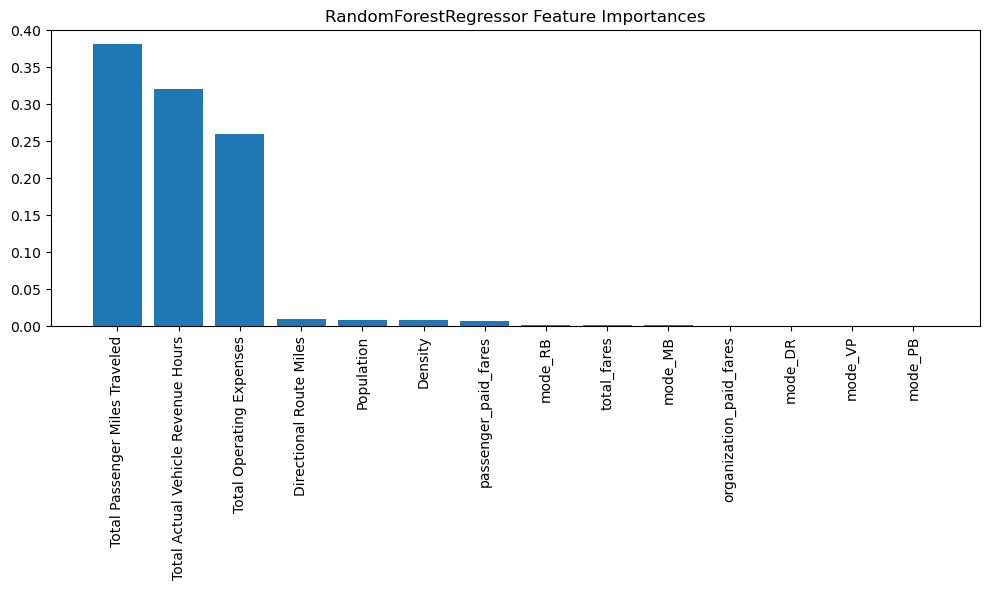

In [14]:
# plotting Feature Importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("RandomForestRegressor Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

#### Logistic Regression

Why did I use this model,

LR is simple and effective classification algorithm. The model optimizes the log-liklehood function to maximize prediction probabilites for the correct class.

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
#LR
# Prepare data
X_clf = refined_data.drop(columns=['Total Unlinked Passenger Trips'])
y_clf = pd.qcut(refined_data['Total Unlinked Passenger Trips'], q=[0, 0.33, 0.67, 1], labels=['Low', 'Medium', 'High'])

# Splitting the data
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Training model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_clf_train, y_clf_train)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [17]:
# LR model prediciton 
y_clf_pred_log = log_reg.predict(X_clf_test)
log_acc = accuracy_score(y_clf_test, y_clf_pred_log)
log_prec = precision_score(y_clf_test, y_clf_pred_log, average='weighted')
log_recall = recall_score(y_clf_test, y_clf_pred_log, average='weighted')
log_f1 = f1_score(y_clf_test, y_clf_pred_log, average='weighted')

print("Logistic Regression Performance:")
print(f"Accuracy: {log_acc}")
print(f"Precision: {log_prec}")
print(f"Recall: {log_recall}")
print(f"F1-score: {log_f1}")


Logistic Regression Performance:
Accuracy: 0.803954802259887
Precision: 0.8158028009566183
Recall: 0.803954802259887
F1-score: 0.8019852538908459


In [19]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prepare data
X_clf = refined_data.drop(columns=['Total Unlinked Passenger Trips'])
y_clf = pd.qcut(refined_data['Total Unlinked Passenger Trips'], q=[0, 0.33, 0.67, 1], labels=['Low', 'Medium', 'High'])

# Split data
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Train model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_clf_train, y_clf_train)



RandomForestClassifier(random_state=42)

In [20]:

# Random forest classifier prediction
y_clf_pred_rf = rf_clf.predict(X_clf_test)
rf_acc = accuracy_score(y_clf_test, y_clf_pred_rf)
rf_prec = precision_score(y_clf_test, y_clf_pred_rf, average='weighted')
rf_recall = recall_score(y_clf_test, y_clf_pred_rf, average='weighted')
rf_f1 = f1_score(y_clf_test, y_clf_pred_rf, average='weighted')

print("Random Forest Classifier Performance:")
print(f"Accuracy: {rf_acc}")
print(f"Precision: {rf_prec}")
print(f"Recall: {rf_recall}")
print(f"F1-score: {rf_f1}")

Random Forest Classifier Performance:
Accuracy: 0.9485875706214689
Precision: 0.9493055122583999
Recall: 0.9485875706214689
F1-score: 0.9487577121855579


RFC showed good performance and was consistant across different ridership categories. The 94% precision shows that the model can be highly reliable for predictions. 

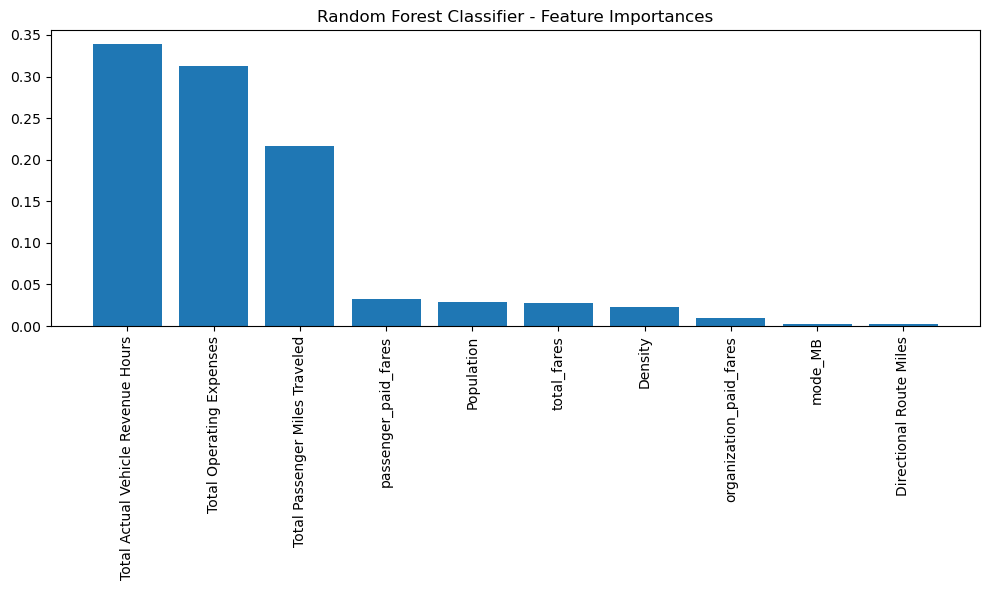

In [21]:
# feature importances for Random Forest Classifier
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order
top_features = [X_clf.columns[i] for i in indices[:10]]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title("Random Forest Classifier - Feature Importances")
plt.bar(range(len(top_features)), importances[indices[:10]], align="center")
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.tight_layout()
plt.show()


The toal vehicle revenue hours, Operating expenses, and passenger miles traveled are the top features. Features like route, and miles influence on ridership. RFC outperformed other models, as it captured non-linear relationship and feature interactions. 

#### Random Forest Regressor

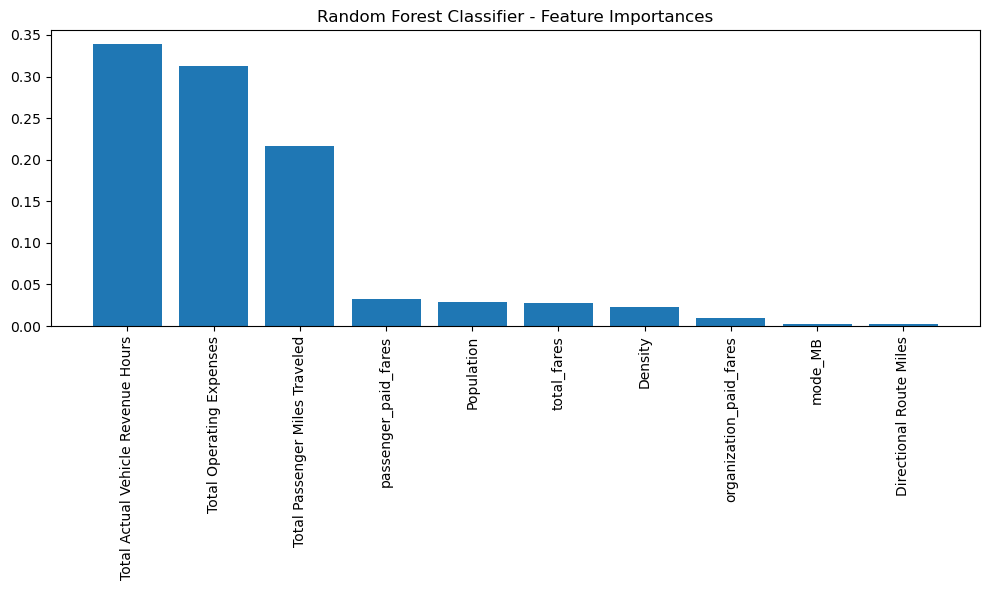

In [22]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance
top_features = [X_clf.columns[i] for i in indices[:10]]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title("Random Forest Classifier - Feature Importances")
plt.bar(range(len(top_features)), importances[indices[:10]], align="center")
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.tight_layout()
plt.show()


#### Gradient Boosting Regressor

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Prepare data
X_reg = refined_data.drop(columns=['Total Unlinked Passenger Trips'])
y_reg = refined_data['Total Unlinked Passenger Trips']

# Split data
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train model
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_reg_train, y_reg_train)




GradientBoostingRegressor(random_state=42)

In [24]:
# Predict and evaluate
y_reg_pred = gb_reg.predict(X_reg_test)
reg_r2 = r2_score(y_reg_test, y_reg_pred)
reg_mae = mean_absolute_error(y_reg_test, y_reg_pred)
reg_mse = mean_squared_error(y_reg_test, y_reg_pred)

print("Gradient Boosting Regressor Performance:")
print(f"R²: {reg_r2}")
print(f"MAE: {reg_mae}")
print(f"MSE: {reg_mse}")

Gradient Boosting Regressor Performance:
R²: 0.9985385955938506
MAE: 148321.0170621875
MSE: 440370187885.5403


The model shows 99% variance in ridership, model effectively captured the relationship between features and ridership. 

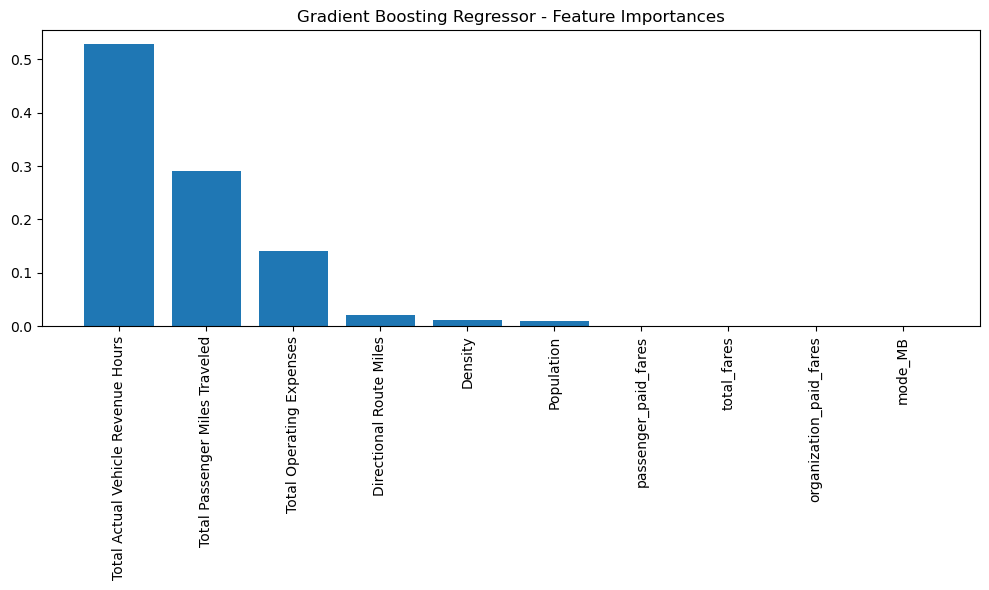

In [25]:
importances = gb_reg.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance
top_features = [X_reg.columns[i] for i in indices[:10]]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title("Gradient Boosting Regressor - Feature Importances")
plt.bar(range(len(top_features)), importances[indices[:10]], align="center")
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.tight_layout()
plt.show()

the high importance of total actual vehicle revenue hours suggests that increasging service coverage, directly coorelates to increase in ridership. Network size contributed positively. 